In [1]:
from losses.losses import ContrastiveLoss
from dataset.datasets import SiameseNetworkDataset
from models.nn import SigmoidSiameseNetwork

from PIL import Image
import numpy as np
import plot
import time

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils
import torchvision

from torch.utils.data import DataLoader
from torch import optim
import torch

In [2]:
# define paths to the training and val sets
TRAIN_DATA_PATH = "./casia_webface/train/"
VAL_DATA_PATH = "./casia_webface/val/"

# define training parameters
EPOCHS = 10
BATCH_SIZE = 128
NUM_WORKERS = 32
IMG_SIZE = 32
LR = 0.0005

In [3]:
# training dataset image folder
train_image_folder = datasets.ImageFolder(root=TRAIN_DATA_PATH)
# apply transformation to the training set
train_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])
# initialize train dataset
train_dataset = SiameseNetworkDataset(imageFolder=train_image_folder,
                                      transform=train_transforms)


# valiation dataset image folder
val_image_folder = datasets.ImageFolder(root=VAL_DATA_PATH)
# apply transformation to the valiation set
val_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                     transforms.ToTensor()])
# initialize valiation dataset
val_dataset = SiameseNetworkDataset(imageFolder=val_image_folder,
                                    transform=val_transforms)
# validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

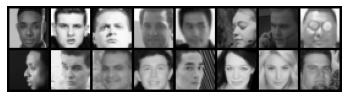

[1. 1. 1. 0. 1. 1. 0. 0.]


In [4]:
# a simple dataloader for visualization
vis_dataloader = DataLoader(val_dataset, batch_size=8)

# extract one batch
example_batch = next(iter(vis_dataloader))

# example batch is a list containing 2x8 images, indexes 0 (neg) and 1 (pos)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

plot.imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [6]:
# initialize the model, loss, and optimizer
net = SigmoidSiameseNetwork().to(device)
print(net)

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

SigmoidSiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        pred = torch.where(outputs > 0.5, 1, 0)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('epoch: {} ({:.0f}%)\trunning_train_loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    
    return train_loss, train_acc

def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2)
            test_loss += criterion(outputs, targets).sum().item()
            pred = torch.where(outputs > 0.5, 1, 0) 
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [8]:
log_interval = 100
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# start training 
for epoch in range(EPOCHS):
    start_time = time.time()
    # training dataloader is initialized for each epoch
    # such that new positive and negative pairs are created
    train_dataloader = DataLoader(train_dataset,
                                  num_workers=NUM_WORKERS,
                                  batch_size=BATCH_SIZE)
    
    train_loss, train_acc = train(net, device, train_dataloader, optimizer, criterion, epoch, log_interval)
    val_loss, val_acc = test(net, device, criterion, val_dataloader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    end_time = time.time()
    print("\n[INFO] epoch: {} | time_per_epoch: {:.2f} sec | avg_train_loss: {:.4f} | avg_train_acc: {:.4f} | avg_val_loss: {:.4f} | avg_val_acc: {:.4f}\n".format(epoch, 
                                                                                                                                             end_time-start_time, 
                                                                                                                                             train_loss, 
                                                                                                                                             train_acc,
                                                                                                                                             val_loss,
                                                                                                                                             val_acc))

epoch: 0 (0%)	running_train_loss: 0.8102
epoch: 0 (3%)	running_train_loss: 0.6694
epoch: 0 (5%)	running_train_loss: 0.6764
epoch: 0 (8%)	running_train_loss: 0.6770
epoch: 0 (11%)	running_train_loss: 0.6757
epoch: 0 (13%)	running_train_loss: 0.6618
epoch: 0 (16%)	running_train_loss: 0.6422
epoch: 0 (19%)	running_train_loss: 0.5688
epoch: 0 (22%)	running_train_loss: 0.5958
epoch: 0 (24%)	running_train_loss: 0.6160
epoch: 0 (27%)	running_train_loss: 0.6754
epoch: 0 (30%)	running_train_loss: 0.5411
epoch: 0 (32%)	running_train_loss: 0.6683
epoch: 0 (35%)	running_train_loss: 0.5540
epoch: 0 (38%)	running_train_loss: 0.5379
epoch: 0 (40%)	running_train_loss: 0.4751
epoch: 0 (43%)	running_train_loss: 0.5839
epoch: 0 (46%)	running_train_loss: 0.4618
epoch: 0 (49%)	running_train_loss: 0.5321
epoch: 0 (51%)	running_train_loss: 0.4764
epoch: 0 (54%)	running_train_loss: 0.5786
epoch: 0 (57%)	running_train_loss: 0.5084
epoch: 0 (59%)	running_train_loss: 0.4635
epoch: 0 (62%)	running_train_loss: 0.5

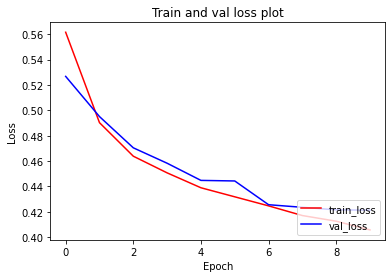

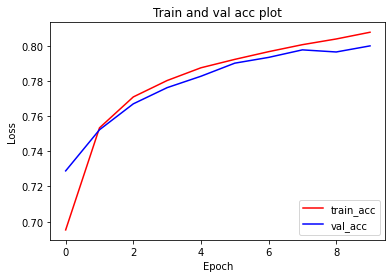

In [9]:
# plot training and validation loss/accuracy
plot.plot_losses(train_losses, val_losses, EPOCHS)
plot.plot_accs(train_accs, val_accs, EPOCHS)

In [10]:
# save the model
torch.save(net.state_dict(), "checkpoints/sigmoid_siamese.pth")